# 2-Data Wrangling Script
Date created: 16/04/23  
Created by: Jayden Dzierbicki  
Last updated: 16/04/23  

The purpose of this notebook is to undertake the following in prepration for machine learning
- Data wrangling and cleaning
- NLP techniques 
- EDA
- Clean data saved and stored into mySQL/csv


In [1]:
# Import necessary libraries and modules
import getpass
from sqlalchemy import create_engine # For connecting to SQL databases
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive
import re
import emoji
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.callbacks import CallbackAny2Vec
import time
import random
from nltk.probability import FreqDist
import seaborn as sns
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')


# Define stop words for text processing
stop_words = set(stopwords.words('english'))


# Function to load data into mySQL
def extract_data_mySQL(database_name, table_name):
    user = 'root'

    # Prompt the user for a password
    password = getpass.getpass("Enter your MySQL password: ")
    host = 'localhost'
    port = 3306
    database = database_name
    engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

    # Write the DataFrame to a SQL table
    table_name =  table_name
    query = f"SELECT * FROM {table_name}"
    
    # Read query to dataframe
    df = pd.read_sql(query, engine)
    return(df)

    # Close the connection
    engine.dispose()
    


# Function to load data into mySQL
def load_data_mySQL(database_name, table_name, df):
    user = 'root'

    # Prompt the user for a password
    password = getpass.getpass("Enter your MySQL password: ")
    host = 'localhost'
    port = 3306
    database = database_name
    engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

    # Write the DataFrame to a SQL table
    table_name =  table_name
    df.to_sql(table_name, engine, if_exists='replace', index=False)

    # Close the connection
    engine.dispose()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data wrangling and cleaning
- Load in data
- Quick EDA of loaded data
- Decsions based on EDA - period of analysis
- Test and remove duplicates i.e. user could spam a forum board 
- NLP

Decsions made in this section include:
- Analysis from 2021-02-02 -> 2023-04-14: Limitations of data retrival for cryptocompare.com

In [3]:
# Load in data sources
cryptocompare_xrp = extract_data_mySQL('MA5851_A3', 'cryptocompare_xrp')
investingcom_xrp = extract_data_mySQL('MA5851_A3', 'investingcom_xrp')
xrp_price_yahoo = extract_data_mySQL('MA5851_A3', 'xrp_price_yahoo')

Enter your MySQL password: ········
Enter your MySQL password: ········
Enter your MySQL password: ········


In [4]:
# View min and max dates for rules on filtering
def get_min_max_dates(table, table_name):
    print(f'Min and max date range of {table_name}')
    print(f'MIN Date: {table.date.min()}')
    print(f'MAX Date: {table.date.max()}')
    print("-----------------------------")


get_min_max_dates(cryptocompare_xrp, "cryptocompare_xrp")
get_min_max_dates(investingcom_xrp, "investingcom_xrp")
get_min_max_dates(xrp_price_yahoo, "xrp_price_yahoo")


Min and max date range of cryptocompare_xrp
MIN Date: 2021-02-02
MAX Date: 2023-04-14
-----------------------------
Min and max date range of investingcom_xrp
MIN Date: 2018-03-16
MAX Date: 2023-04-14
-----------------------------
Min and max date range of xrp_price_yahoo
MIN Date: 2017-11-10 00:00:00
MAX Date: 2023-04-14 00:00:00
-----------------------------


In [5]:
# Filter all data by date range, using data from 2021-02-02 onwards
min_date_filter = pd.to_datetime('2021-02-02')  # Used to filter min date

def filter_by_min_date(date_filter, df, table_name):
    df['date'] = pd.to_datetime(df['date'])
    filtered_df = df[df['date'] >= date_filter]
    rows_removed = len(df) - len(filtered_df)
    print(f"Number of rows filtered by date from {table_name}: {rows_removed}")
    print("---------------------------------------------------------")
    return filtered_df

filtered_investingcom_xrp = filter_by_min_date(min_date_filter, investingcom_xrp, "investingcom_xrp")
filtered_xrp_price_yahoo = filter_by_min_date(min_date_filter, xrp_price_yahoo, "xrp_price_yahoo")
filtered_cryptocompare_xrp = filter_by_min_date(min_date_filter, cryptocompare_xrp, "cryptocompare_xrp")


Number of rows filtered by date from investingcom_xrp: 26268
---------------------------------------------------------
Number of rows filtered by date from xrp_price_yahoo: 1180
---------------------------------------------------------
Number of rows filtered by date from cryptocompare_xrp: 0
---------------------------------------------------------


In [6]:
# Remove NA observations from comments
def remove_na_values(df, table_name, variable):
    output = df.dropna(subset=[variable])
    rows_removed = len(df) - len(output)
    print(f"Number of NA rows removed from {table_name}: {rows_removed}")
    print("---------------------------------------------------------")
    return output

# Assuming cryptocompare_xrp is a pandas DataFrame with a 'comment' column
cleaned_cryptocompare_xrp = remove_na_values(filtered_investingcom_xrp, "cryptocompare_xrp", "comment")
cleaned_investingcom_xrp = remove_na_values(filtered_cryptocompare_xrp, "investingcom_xrp", "comment")


Number of NA rows removed from cryptocompare_xrp: 43
---------------------------------------------------------
Number of NA rows removed from investingcom_xrp: 129
---------------------------------------------------------


In [7]:
# Remove duplicates for multiple posts on same day - could be spam

def preview_duplicate_comments(df, table_name):
    # Find duplicates based on 'date' and 'comment' columns
    duplicates = df[df.duplicated(subset=['date', 'comment'], keep=False)]

    # Group the duplicates by 'date' and 'comment' columns and count their occurrences
    duplicate_counts = duplicates.groupby(['date', 'comment']).size().reset_index(name='count')

    # Sort the DataFrame by the 'count' column in descending order
    duplicate_counts_sorted = duplicate_counts.sort_values(by='count', ascending=False)

    # Print the count for each specific duplicate
    print(f"Duplicate preview for {table_name}")
    print(duplicate_counts_sorted)
    print("-------------------------------------------------------------------------")

def remove_duplicate_comments(df, table_name):
    # Remove duplicates
    unique_df = df.drop_duplicates(subset=['date', 'comment'])
    duplicates_removed = len(df) - len(unique_df)
    print(f'Number of duplicates removed from {table_name}: {duplicates_removed}')
    print("-------------------------------------------------------------------------")
    return unique_df

# Preview and remove duplicates
preview_duplicate_comments(cleaned_cryptocompare_xrp, "cleaned_cryptocompare_xrp")
preview_duplicate_comments(cleaned_investingcom_xrp, "cleaned_investingcom_xrp")

cleaned_cryptocompare_xrp_2 = remove_duplicate_comments(cleaned_cryptocompare_xrp, "cleaned_cryptocompare_xrp")
cleaned_investingcom_xrp_2 = remove_duplicate_comments(cleaned_investingcom_xrp, "cleaned_investingcom_xrp")

Duplicate preview for cleaned_cryptocompare_xrp
          date                                            comment  count
124 2021-04-13                                                lol      6
96  2021-04-10                                                lol      5
38  2021-02-21                                            shut up      4
105 2021-04-11  My newbie opinion: if price break 1.3200, it m...      4
25  2021-02-14  Guys, how long do u suppose this place of resi...      4
..         ...                                                ...    ...
118 2021-04-13  Im not selling a penny till we beat the SEC an...      2
117 2021-04-13                                   Here we go again      2
116 2021-04-13                                              HODL🚀      2
115 2021-04-13                                              Bitso      2
337 2022-11-18  Exactly! Even 10% of swift business puts this ...      2

[338 rows x 3 columns]
----------------------------------------------------

In [8]:
# Join text data together retaining date, source and comment
text_data = pd.concat([cleaned_investingcom_xrp_2, cleaned_cryptocompare_xrp_2])[['date', 'source', 'comment']]

# create a new dataframe with the count of comments by date and source
count_data = text_data.groupby(['date', 'source']).size().reset_index(name='count')

# calculate the average number of posts per day - all sources
avg_posts_per_day = count_data.groupby('date')['count'].mean().mean()
print('Average number of posts per day: {:.2f}'.format(avg_posts_per_day))

# calculate the median number of posts per day - all sources
med_posts_per_day = count_data.groupby('date')['count'].median().median()
print('Median number of posts per day: {:.2f}'.format(med_posts_per_day))

print("------------------------------------------------")

# Create a new dataframe with the count of comments by date and source
count_data = text_data.groupby(['date', 'source']).size().reset_index(name='count')

# Calculate the average number of posts per day by source
avg_posts_per_day_by_source = count_data.groupby('source')['count'].mean()
print('Average number of posts per day by source:')
print(avg_posts_per_day_by_source)

# Calculate the median number of posts per day by source
med_posts_per_day_by_source = count_data.groupby('source')['count'].median()
print('\nMedian number of posts per day by source:')
print(med_posts_per_day_by_source)


Average number of posts per day: 24.84
Median number of posts per day: 8.50
------------------------------------------------
Average number of posts per day by source:
source
https://www.cryptocompare.com/coins/xrp/forum     8.011524
https://www.investing.com/crypto/xrp/chat        44.378523
Name: count, dtype: float64

Median number of posts per day by source:
source
https://www.cryptocompare.com/coins/xrp/forum     5.0
https://www.investing.com/crypto/xrp/chat        13.0
Name: count, dtype: float64


In [9]:

# define a function that plots the count of comments for a given date range
def plot_comments(start_date, end_date):
    start_date = np.datetime64(start_date)
    end_date = np.datetime64(end_date)
    data = count_data[(count_data['date'] >= start_date) & (count_data['date'] <= end_date)]
    fig, ax = plt.subplots(figsize=(12, 6))
    for source in data['source'].unique():
        source_data = data[data['source'] == source]
        ax.plot(source_data['date'], source_data['count'], label=source)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of comments')
    ax.set_title('Number of comments by source and date')
    ax.legend()
    plt.show()


# create a date slider widget
start_date_widget = widgets.DatePicker(description='Start date:', value=min(count_data['date']))
end_date_widget = widgets.DatePicker(description='End date:', value=max(count_data['date']))

# create an interactive plot using the date slider widget
interactive_plot = interactive(plot_comments, start_date=start_date_widget, end_date=end_date_widget)
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot


interactive(children=(DatePicker(value=Timestamp('2021-02-02 00:00:00'), description='Start date:'), DatePicke…

In [9]:
text_data

,date,source,comment
0,2023-04-14,https://www.cryptocompare.com/coins/xrp/forum,"moon soon, coon. mark my words (lol idk - no f..."
1,2023-04-14,https://www.cryptocompare.com/coins/xrp/forum,Boring xrp at the Moment
2,2023-04-14,https://www.cryptocompare.com/coins/xrp/forum,So bankrupted FTX….they recover $7.3 billion i...
3,2023-04-13,https://www.cryptocompare.com/coins/xrp/forum,Is UMU what many thought XRP was going to be u...
4,2023-04-13,https://www.cryptocompare.com/coins/xrp/forum,Coinbase just deposited Flare into my account....
...,...,...,...
33475,2021-02-02,https://www.investing.com/crypto/xrp/chat,XRP=PORTELO
33476,2021-02-02,https://www.investing.com/crypto/xrp/chat,new smart move is xlm stellar!✌
33477,2021-02-02,https://www.investing.com/crypto/xrp/chat,xlm is not scammy enough
33478,2021-02-02,https://www.investing.com/crypto/xrp/chat,buyyy


### Graph Intepreation & Next steps:
During the period between March and April of 2020-2021, there were significant developments in the legal battle between SEC and Ripple, which is reflected in the online forum discussions. This increase in discussions was particularly noticeable on the Cryptocompare platform, with a substantial spike during that period. For more information on the SEC vs. Ripple lawsuit, refer to this article: https://cointelegraph.com/learn/the-sec-vs-ripple-lawsuit-everything-you-need-to-know.

#### At this stage we have commpleted the following tasks:
- Filtered all data 
- Remove missing observations
- Remove duplicates
- Joined text data together & quick EDA of sample distrubtion



## Word2Vec Feature Extraction
- Text cleanining (unwanted characters, HTML elements, conver to lower case etc)
- Tokenization (Tokenize the text data into indivdual workds or tokens)
- Stopword removal (debating as this can loose meaning of word)
- Lemmatization or stemming (debating)

Finally XRP price will be added to dataframe and exported to mySQL for machine elarning model

In [10]:
# Explore impact on model by removing stop words or keeping


def remove_stopwords_and_lemmatize(text):
    # Set up stop words
    stop_words = set(stopwords.words("english"))
    # Remove stop words and lemmatize words
    lemmatizer = WordNetLemmatizer()
    no_stopword_text = [lemmatizer.lemmatize(w) for w in words_list if not w in stop_words]
    return no_stopword_text





def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URL
    text = text.lower()
    # Replace punctuation with spaces using the string module and the translate() method
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Apply stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens]
    # Return the list of stemmed and lemmatized words
    return stemmed_tokens

def clean_text_stop_words(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URL from text
    text = text.lower()
    # Replace punctuation with spaces using the string module and the translate() method
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Apply stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens]
    # Return the list of stemmed and lemmatized words
    return stemmed_tokens





In [11]:
# Clean all the comments in the 'comment' column of the DataFrame
text_data['cleaned_comment'] = text_data['comment'].apply(clean_text)
text_data['cleaned_comment_stop'] = text_data['comment'].apply(clean_text_stop_words)
text_data

,date,source,comment,cleaned_comment,cleaned_comment_stop
0,2023-04-14,https://www.cryptocompare.com/coins/xrp/forum,"moon soon, coon. mark my words (lol idk - no f...","[moon, soon, coon, mark, my, word, lol, idk, n...","[moon, soon, coon, mark, word, lol, idk, finan..."
1,2023-04-14,https://www.cryptocompare.com/coins/xrp/forum,Boring xrp at the Moment,"[bore, xrp, at, the, moment]","[bore, xrp, moment]"
2,2023-04-14,https://www.cryptocompare.com/coins/xrp/forum,So bankrupted FTX….they recover $7.3 billion i...,"[so, bankrupt, ftx…, they, recov, 7, 3, billio...","[bankrupt, ftx…, recov, 7, 3, billion, assets😂..."
3,2023-04-13,https://www.cryptocompare.com/coins/xrp/forum,Is UMU what many thought XRP was going to be u...,"[is, umu, what, mani, thought, xrp, wa, go, to...","[umu, mani, thought, xrp, go, use, genuin, que..."
4,2023-04-13,https://www.cryptocompare.com/coins/xrp/forum,Coinbase just deposited Flare into my account....,"[coinbas, just, deposit, flare, into, my, acco...","[coinbas, deposit, flare, account, anyon, els,..."
...,...,...,...,...,...
33475,2021-02-02,https://www.investing.com/crypto/xrp/chat,XRP=PORTELO,"[xrp, portelo]","[xrp, portelo]"
33476,2021-02-02,https://www.investing.com/crypto/xrp/chat,new smart move is xlm stellar!✌,"[new, smart, move, is, xlm, stellar, ✌]","[new, smart, move, xlm, stellar, ✌]"
33477,2021-02-02,https://www.investing.com/crypto/xrp/chat,xlm is not scammy enough,"[xlm, is, not, scammi, enough]","[xlm, scammi, enough]"
33478,2021-02-02,https://www.investing.com/crypto/xrp/chat,buyyy,[buyyy],[buyyy]


In [12]:
# Prep word2vec model cleaned coment stop only
tokenized_data = text_data['cleaned_comment_stop']


# Callback class
class callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()

        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        elif self.epoch % 100 == 0:
            loss_difference = loss - self.loss_previous_step
            print('Loss after epoch {}: {}'.format(self.epoch, loss_difference))
            self.losses.append(loss_difference)

        self.epoch += 1
        self.loss_previous_step = loss

    def plot_losses(self):
        plt.plot(range(100, len(self.losses) * 100 + 1, 100), self.losses)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss over Epochs")
        plt.show()


# Set the random seed for numpy
np.random.seed(42)

# Word2Vec model
# Workers set to 1 to ensure set seed 42 works correctly for reproducibility
w2v_model = Word2Vec(vector_size=200, window=15, min_count=2, workers=1, sg=1, negative=5, sample=1e-5, seed=42)

# Build vocab
w2v_model.build_vocab(tokenized_data)

# Create the callback instance
cb = callback()

# Train the model
start = time.time()
w2v_model.train(tokenized_data, total_examples=w2v_model.corpus_count, epochs=1501, report_delay=1, compute_loss=True, callbacks=[cb])
end = time.time()

# Plot the losses
cb.plot_losses()

print("elapsed time in seconds :" + str(end - start))




Loss after epoch 0: 999766.8125


KeyboardInterrupt: 

In [12]:
# Set the random seed for numpy
np.random.seed(42)

# Word2Vec model
# Workers set to 1 to ensure set seed 42 works correctly for reproducibility
w2v_model = Word2Vec(vector_size=200, window=15, min_count=2, workers=1, sg=1, negative=5, sample=1e-5, seed=42)

# Build vocab
w2v_model.build_vocab(tokenized_data)

# Create the callback instance
cb = callback()

# Train the model
start = time.time()
w2v_model.train(tokenized_data, total_examples=w2v_model.corpus_count, epochs=401, report_delay=1, compute_loss=True, callbacks=[cb])
end = time.time()

# Plot the losses
cb.plot_losses()

print("elapsed time in seconds :" + str(end - start))

NameError: name 'tokenized_data' is not defined

In [14]:
# Prepere model for machine learning
df = text_data[['date', 'cleaned_comment_stop']]

# Function to compute the average word vector for a list of tokens
def average_word_vectors(tokens, model, vector_size):
    word_vectors = [model.wv[token] for token in tokens if token in model.wv]
    if not word_vectors:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

# Add average word vector columns to the DataFrame
vector_size = 200  # Update this to match the vector_size of your Word2Vec model
for i in range(vector_size):
    df[f'w2v_{i}'] = df['cleaned_comment_stop'].apply(lambda tokens: average_word_vectors(tokens, w2v_model, vector_size)[i])


df

C:\Users\jayde\AppData\Local\Temp/ipykernel_47548/3352759084.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'w2v_{i}'] = df['cleaned_comment_stop'].apply(lambda tokens: average_word_vectors(tokens, w2v_model, vector_size)[i])
C:\Users\jayde\AppData\Local\Temp/ipykernel_47548/3352759084.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'w2v_{i}'] = df['cleaned_comment_stop'].apply(lambda tokens: average_word_vectors(tokens, w2v_model, vector_size)[i])


,date,cleaned_comment_stop,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,...,w2v_190,w2v_191,w2v_192,w2v_193,w2v_194,w2v_195,w2v_196,w2v_197,w2v_198,w2v_199
0,2023-04-14,"[moon, soon, coon, mark, word, lol, idk, finan...",0.125699,-0.084157,-0.014475,-0.281343,0.234461,-0.018758,0.024299,-0.006080,...,0.037735,0.007112,0.164615,-0.150603,0.135687,-0.212896,0.140418,0.163704,-0.116994,-0.013637
1,2023-04-14,"[bore, xrp, moment]",0.012810,0.024022,0.106435,0.042587,0.029515,-0.032976,0.050560,-0.109967,...,0.118931,-0.022657,-0.166424,-0.242655,0.121198,0.100250,-0.042547,0.302491,0.289107,-0.172740
2,2023-04-14,"[bankrupt, ftx…, recov, 7, 3, billion, assets😂...",0.235348,-0.008856,-0.012530,0.009834,0.221187,0.096044,-0.293966,-0.123075,...,0.291762,-0.018756,-0.217277,-0.336877,0.327262,-0.098863,-0.045248,0.091254,-0.044882,0.139843
3,2023-04-13,"[umu, mani, thought, xrp, go, use, genuin, que...",0.054528,-0.049179,-0.097194,-0.170965,0.064942,-0.052883,0.086148,0.057874,...,-0.073224,0.009781,-0.019037,-0.139613,0.057395,-0.113451,-0.068765,0.113306,0.226157,0.008557
4,2023-04-13,"[coinbas, deposit, flare, account, anyon, els,...",0.136945,0.163111,0.232670,-0.064369,-0.074094,-0.040550,0.088761,0.032003,...,-0.059979,0.025915,-0.051659,-0.139419,0.226637,-0.066050,-0.162678,0.345504,0.205884,0.236297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33475,2021-02-02,"[xrp, portelo]",-0.005929,0.055750,0.005746,-0.038872,-0.046093,0.120452,-0.030068,-0.007228,...,-0.036488,0.001205,-0.054628,-0.070905,0.117953,-0.116090,-0.065126,0.139350,0.056996,-0.056345
33476,2021-02-02,"[new, smart, move, xlm, stellar, ✌]",-0.233411,0.269422,-0.135192,-0.110167,0.369804,-0.039920,-0.492694,0.004783,...,-0.214493,0.020972,0.310329,-0.077189,0.040837,-0.416922,-0.101099,0.135169,0.117311,-0.132409
33477,2021-02-02,"[xlm, scammi, enough]",-0.362511,0.588064,0.101727,0.059318,0.788563,-0.009542,-0.125330,-0.069963,...,-0.364881,0.180392,-0.000017,-0.262109,0.186249,-0.308738,-0.171216,0.037092,-0.094233,0.084721
33478,2021-02-02,[buyyy],-0.031721,0.060457,-0.120519,-0.042399,0.090584,-0.067445,-0.188823,0.355463,...,-0.082054,0.217192,-0.043048,-0.324209,-0.025054,-0.290235,-0.090396,0.066295,-0.114879,0.165541


In [42]:
# Remove cleaned comment due to error with mySQL - not crucial as we have extracted features via w2v
df2 = df
df2 = df2.drop('cleaned_comment_stop', axis=1) 


# Retain date, close and open of historical XRP price
filtered_xrp_price_yahoo_movment = filtered_xrp_price_yahoo
selected_cols = ['date', 'close', 'open', 'high', 'low', 'volume']
filtered_xrp_price_yahoo_movment = filtered_xrp_price_yahoo_movment[selected_cols]
filtered_xrp_price_yahoo_movment

# Lag high and low prices by one day
filtered_xrp_price_yahoo_movment['high_lag1'] = filtered_xrp_price_yahoo_movment['high'].shift(1)
filtered_xrp_price_yahoo_movment['low_lag1'] = filtered_xrp_price_yahoo_movment['low'].shift(1)
filtered_xrp_price_yahoo_movment['vol_lag1'] = filtered_xrp_price_yahoo_movment['volume'].shift(1)

# Drop the first row which contains NaN values due to the shift
filtered_xrp_price_yahoo_movment.dropna(inplace=True)
filtered_xrp_price_yahoo_movment = filtered_xrp_price_yahoo_movment.drop(columns=['high', 'low', 'volume'])
filtered_xrp_price_yahoo_movment
# Merge w2v model with XRP open close price via date
data = pd.merge(df2, filtered_xrp_price_yahoo_movment)
data

C:\Users\jayde\AppData\Local\Temp/ipykernel_47548/1954790325.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_xrp_price_yahoo_movment['high_lag1'] = filtered_xrp_price_yahoo_movment['high'].shift(1)
C:\Users\jayde\AppData\Local\Temp/ipykernel_47548/1954790325.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_xrp_price_yahoo_movment['low_lag1'] = filtered_xrp_price_yahoo_movment['low'].shift(1)
C:\Users\jayde\AppData\Local\Temp/ipykernel_47548/1954790325.py:15: SettingWithCopyWarning

,date,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,...,w2v_195,w2v_196,w2v_197,w2v_198,w2v_199,close,open,high_lag1,low_lag1,vol_lag1
0,2023-04-14,0.125699,-0.084157,-0.014475,-0.281343,0.234461,-0.018758,0.024299,-0.006080,-0.098194,...,-0.212896,0.140418,0.163704,-0.116994,-0.013637,0.756639,0.754341,0.778733,0.749323,1.587787e+09
1,2023-04-14,0.012810,0.024022,0.106435,0.042587,0.029515,-0.032976,0.050560,-0.109967,0.272579,...,0.100250,-0.042547,0.302491,0.289107,-0.172740,0.756639,0.754341,0.778733,0.749323,1.587787e+09
2,2023-04-14,0.235348,-0.008856,-0.012530,0.009834,0.221187,0.096044,-0.293966,-0.123075,0.196704,...,-0.098863,-0.045248,0.091254,-0.044882,0.139843,0.756639,0.754341,0.778733,0.749323,1.587787e+09
3,2023-04-14,0.600491,0.226066,-0.087595,-0.285206,-0.040463,0.252654,-0.232520,0.100139,0.275738,...,-0.249416,-0.324616,0.269155,-0.131536,-0.029065,0.756639,0.754341,0.778733,0.749323,1.587787e+09
4,2023-04-13,0.054528,-0.049179,-0.097194,-0.170965,0.064942,-0.052883,0.086148,0.057874,0.112599,...,-0.113451,-0.068765,0.113306,0.226157,0.008557,0.755734,0.777921,0.788820,0.772128,1.813208e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38901,2021-06-26,0.234124,0.066945,-0.050151,-0.137008,0.221813,0.296963,-0.100789,-0.032571,0.063648,...,0.198309,-0.207165,0.179944,0.116979,0.291483,0.811171,0.806097,0.906713,0.795322,4.113540e+09
38902,2021-06-26,0.022859,-0.014483,0.152138,-0.126525,-0.020228,0.121150,-0.049165,0.123964,0.121123,...,-0.030453,-0.039819,0.255588,-0.028857,-0.021020,0.811171,0.806097,0.906713,0.795322,4.113540e+09
38903,2021-06-26,0.113765,0.095062,-0.053988,0.015174,-0.105670,0.251508,0.096604,-0.006029,0.087672,...,0.085325,0.009243,0.244631,0.176477,-0.006264,0.811171,0.806097,0.906713,0.795322,4.113540e+09
38904,2021-06-26,-0.192875,0.010376,0.044612,-0.017013,-0.128105,-0.052010,0.344926,-0.185524,-0.052127,...,-0.121864,0.093610,0.450165,0.053265,-0.024766,0.811171,0.806097,0.906713,0.795322,4.113540e+09


In [43]:
# Split 'date' column into separate features and set date as index: THis will remove it as a feature
data['date'] = pd.to_datetime(data['date'])
#data['year'] = data['date'].dt.year
#data['month'] = data['date'].dt.month
#data['day'] = data['date'].dt.day
#data.set_index('date', inplace=True)

# Confirm that it workds
data

,date,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,...,w2v_195,w2v_196,w2v_197,w2v_198,w2v_199,close,open,high_lag1,low_lag1,vol_lag1
0,2023-04-14,0.125699,-0.084157,-0.014475,-0.281343,0.234461,-0.018758,0.024299,-0.006080,-0.098194,...,-0.212896,0.140418,0.163704,-0.116994,-0.013637,0.756639,0.754341,0.778733,0.749323,1.587787e+09
1,2023-04-14,0.012810,0.024022,0.106435,0.042587,0.029515,-0.032976,0.050560,-0.109967,0.272579,...,0.100250,-0.042547,0.302491,0.289107,-0.172740,0.756639,0.754341,0.778733,0.749323,1.587787e+09
2,2023-04-14,0.235348,-0.008856,-0.012530,0.009834,0.221187,0.096044,-0.293966,-0.123075,0.196704,...,-0.098863,-0.045248,0.091254,-0.044882,0.139843,0.756639,0.754341,0.778733,0.749323,1.587787e+09
3,2023-04-14,0.600491,0.226066,-0.087595,-0.285206,-0.040463,0.252654,-0.232520,0.100139,0.275738,...,-0.249416,-0.324616,0.269155,-0.131536,-0.029065,0.756639,0.754341,0.778733,0.749323,1.587787e+09
4,2023-04-13,0.054528,-0.049179,-0.097194,-0.170965,0.064942,-0.052883,0.086148,0.057874,0.112599,...,-0.113451,-0.068765,0.113306,0.226157,0.008557,0.755734,0.777921,0.788820,0.772128,1.813208e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38901,2021-06-26,0.234124,0.066945,-0.050151,-0.137008,0.221813,0.296963,-0.100789,-0.032571,0.063648,...,0.198309,-0.207165,0.179944,0.116979,0.291483,0.811171,0.806097,0.906713,0.795322,4.113540e+09
38902,2021-06-26,0.022859,-0.014483,0.152138,-0.126525,-0.020228,0.121150,-0.049165,0.123964,0.121123,...,-0.030453,-0.039819,0.255588,-0.028857,-0.021020,0.811171,0.806097,0.906713,0.795322,4.113540e+09
38903,2021-06-26,0.113765,0.095062,-0.053988,0.015174,-0.105670,0.251508,0.096604,-0.006029,0.087672,...,0.085325,0.009243,0.244631,0.176477,-0.006264,0.811171,0.806097,0.906713,0.795322,4.113540e+09
38904,2021-06-26,-0.192875,0.010376,0.044612,-0.017013,-0.128105,-0.052010,0.344926,-0.185524,-0.052127,...,-0.121864,0.093610,0.450165,0.053265,-0.024766,0.811171,0.806097,0.906713,0.795322,4.113540e+09


In [44]:
# One-hot encode 'year', 'month', and 'day' columns
#data = pd.get_dummies(data, columns=['month', 'day'])
#data
data

,date,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,...,w2v_195,w2v_196,w2v_197,w2v_198,w2v_199,close,open,high_lag1,low_lag1,vol_lag1
0,2023-04-14,0.125699,-0.084157,-0.014475,-0.281343,0.234461,-0.018758,0.024299,-0.006080,-0.098194,...,-0.212896,0.140418,0.163704,-0.116994,-0.013637,0.756639,0.754341,0.778733,0.749323,1.587787e+09
1,2023-04-14,0.012810,0.024022,0.106435,0.042587,0.029515,-0.032976,0.050560,-0.109967,0.272579,...,0.100250,-0.042547,0.302491,0.289107,-0.172740,0.756639,0.754341,0.778733,0.749323,1.587787e+09
2,2023-04-14,0.235348,-0.008856,-0.012530,0.009834,0.221187,0.096044,-0.293966,-0.123075,0.196704,...,-0.098863,-0.045248,0.091254,-0.044882,0.139843,0.756639,0.754341,0.778733,0.749323,1.587787e+09
3,2023-04-14,0.600491,0.226066,-0.087595,-0.285206,-0.040463,0.252654,-0.232520,0.100139,0.275738,...,-0.249416,-0.324616,0.269155,-0.131536,-0.029065,0.756639,0.754341,0.778733,0.749323,1.587787e+09
4,2023-04-13,0.054528,-0.049179,-0.097194,-0.170965,0.064942,-0.052883,0.086148,0.057874,0.112599,...,-0.113451,-0.068765,0.113306,0.226157,0.008557,0.755734,0.777921,0.788820,0.772128,1.813208e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38901,2021-06-26,0.234124,0.066945,-0.050151,-0.137008,0.221813,0.296963,-0.100789,-0.032571,0.063648,...,0.198309,-0.207165,0.179944,0.116979,0.291483,0.811171,0.806097,0.906713,0.795322,4.113540e+09
38902,2021-06-26,0.022859,-0.014483,0.152138,-0.126525,-0.020228,0.121150,-0.049165,0.123964,0.121123,...,-0.030453,-0.039819,0.255588,-0.028857,-0.021020,0.811171,0.806097,0.906713,0.795322,4.113540e+09
38903,2021-06-26,0.113765,0.095062,-0.053988,0.015174,-0.105670,0.251508,0.096604,-0.006029,0.087672,...,0.085325,0.009243,0.244631,0.176477,-0.006264,0.811171,0.806097,0.906713,0.795322,4.113540e+09
38904,2021-06-26,-0.192875,0.010376,0.044612,-0.017013,-0.128105,-0.052010,0.344926,-0.185524,-0.052127,...,-0.121864,0.093610,0.450165,0.053265,-0.024766,0.811171,0.806097,0.906713,0.795322,4.113540e+09


In [45]:
load_data_mySQL('MA5851_A3', 'ltsm_data_frame', data)


Enter your MySQL password: ········


## EDA
We will utilise text_data['cleaned_comment_stop'] for our exploration as this was used to build our word2vec model, and we will also utilise data to get an undertsanding of open and close price. Our objective here will to be explore the follwoing:
- Histroical price
- Corpus of text



In [19]:
words = list(w2v_model.wv.key_to_index)
print('Vocab size: '+str(len(words)))

w1 = 'xrp'
print("Top 3 words similar to {w}:".format(w=w1), w2v_model.wv.most_similar(positive = w1,topn =3))

w1 = 'sec'
print("Top 3 words similar to {w}:".format(w=w1), w2v_model.wv.most_similar(positive = w1,topn =3))

w1 = 'meme'
print("Top 3 words similar to {w}:".format(w=w1), w2v_model.wv.most_similar(positive = w1,topn =3))

w1 = 'gensler'
print("Top 3 words similar to {w}:".format(w=w1), w2v_model.wv.most_similar(positive = w1,topn =3))

w1 = 'hodl'
print("Top 3 words similar to {w}:".format(w=w1), w2v_model.wv.most_similar(positive = w1,topn =3))

w1 = 'lab'
print("Top 3 words similar to {w}:".format(w=w1), w2v_model.wv.most_similar(positive = w1,topn =3))

Vocab size: 8559
Top 3 words similar to xrp: [('rippl', 0.7138864398002625), ('show', 0.6888630986213684), ('coin', 0.6730276346206665)]
Top 3 words similar to sec: [('rippl', 0.8073084950447083), ('case', 0.804876983165741), ('lawsuit', 0.7215989828109741)]
Top 3 words similar to meme: [('unaccept', 0.5286688804626465), ('rap', 0.5117706656455994), ('boomer', 0.4783424735069275)]
Top 3 words similar to gensler: [('gari', 0.7387188673019409), ('nomine', 0.5521851778030396), ('faction', 0.47370004653930664)]
Top 3 words similar to hodl: [('winer', 0.5292115211486816), ('att', 0.44229626655578613), ('✈️❤️', 0.4250231981277466)]
Top 3 words similar to lab: [('courtsouthern', 0.5044182538986206), ('💥💥💥', 0.48758387565612793), ('gape', 0.46044936776161194)]


C:\Users\jayde\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


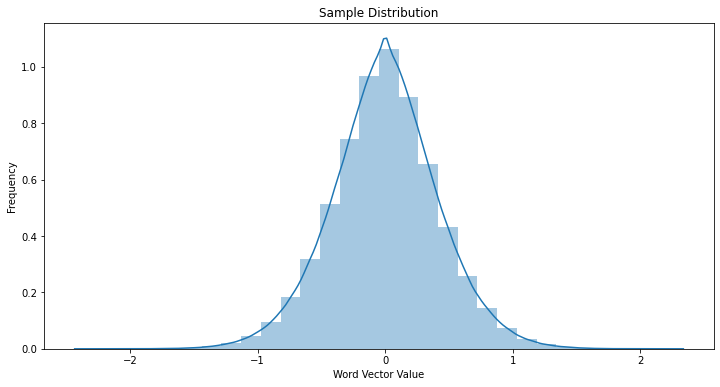

In [54]:
sample_data = w2v_model.wv.vectors

plt.figure(figsize=(12, 6))
sns.distplot(sample_data, kde=True, hist=True, bins=30)
plt.title('Sample Distribution')
plt.xlabel('Word Vector Value')
plt.ylabel('Frequency')
plt.show()


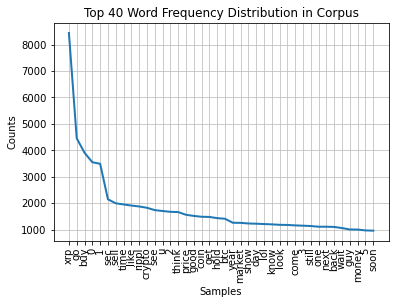

In [53]:
tokenized_corpus = text_data['cleaned_comment_stop']

# Flatten the list of lists containing tokenized words
flat_tokenized_corpus = [word for tokens in tokenized_corpus for word in tokens]

fdist = FreqDist(flat_tokenized_corpus)
top_n = 40
fdist.plot(top_n, cumulative=False, title=f'Top {top_n} Word Frequency Distribution in Corpus')
plt.show()



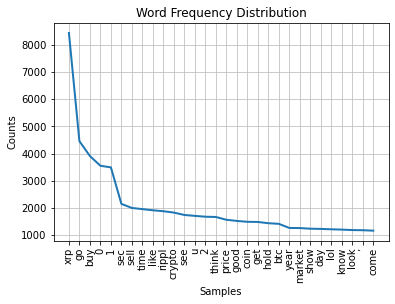

In [41]:


tokens = [token for comment in text_data['cleaned_comment_stop'] for token in comment]
fdist = FreqDist(tokens)
fdist.plot(30, cumulative=False, title='Word Frequency Distribution')
plt.show()
